# Dense MLP - Template

This notebook provides a **template** for creating a Dense MLP classifier. It illustrates how to use the following techniques/tricks as needed for an experiment.


- Batch Normalization
- Dropout regularization
- Early Stopping
- Learning curve


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras

## Load The Dataset

- Load the MNIST data
- Create a separate validation set
- Scale the data

In [2]:
mnist = keras.datasets.mnist

# Load the full training & test data
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()


# Create validation dataset as well as scale the data
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

print("No. of Training Samples: ", X_train.shape)
print("No. of Training Labels: ", y_train.shape)

print("\nNo. of Validation Samples: ", X_valid.shape)
print("No. of Validation Labels: ", y_valid.shape)

print("\nNo. of Testing Samples: ", X_test.shape)
print("No. of Testing Labels: ", y_test.shape)

print("\nX type: ", X_train.dtype)
print("y type: ", y_train.dtype)

No. of Training Samples:  (55000, 28, 28)
No. of Training Labels:  (55000,)

No. of Validation Samples:  (5000, 28, 28)
No. of Validation Labels:  (5000,)

No. of Testing Samples:  (10000, 28, 28)
No. of Testing Labels:  (10000,)

X type:  float64
y type:  uint8


## Create the Model

Couple of things to note.

- At first, flatten the input using the Flatten layer. Need to specify the input shape.


- Order of adding layers: Dense --> Batch Normalization --> Activation --> Dropout


- For each Dense layer, specify (a) number of neurons (units), (b) weight initializer (kernel_initializer), (c) activation function should be set to "None".

Find a suitable weight initializer (using the kernel_initializer argument) from the following link:
https://keras.io/api/layers/initializers/#available-initializers

- For the Batch Normalizatio layer, use the default values of the parameters.
https://keras.io/api/layers/normalization_layers/batch_normalization/


- Find a suitable activation function (using the activation argument) from the following link:
https://keras.io/api/layers/activations/#available-activations


- If need be, add Dropout layers after the activation. Only set the "rate" parameter.
https://keras.io/api/layers/regularization_layers/dropout/

In [3]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential(name="DenseClassifier")
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(units=300, kernel_initializer="he_normal", activation=None))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu")) 
keras.layers.Dropout(rate=0.1)
model.add(keras.layers.Dense(units=100, kernel_initializer="he_normal", activation=None))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
keras.layers.Dropout(rate=0.1)
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "DenseClassifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)           

## Train the Model

Couple of things to note.

For compiling the model, select a suitable:
- Loss function: https://keras.io/api/losses/
- Optimizer: https://keras.io/api/optimizers/
- Performance metrics: https://keras.io/api/metrics/

Use the EarlyStopping callback function to implement early stopping. Set the "monitor" parameter with either "val_loss" or "val_accuracy". Another parameter to set is "patience".
https://keras.io/api/callbacks/early_stopping/

To train the model using the "fit" method, set the following parameters.
- Training data & label
- Batch size
- Number of epochs
- Verbose
- Validation data & label
- Callback

In [4]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.Adam()


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 20
size_of_mini_batch = 32

history = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2180 - accuracy: 0.9367 - val_loss: 0.1038 - val_accuracy: 0.9690
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1032 - accuracy: 0.9682 - val_loss: 0.0823 - val_accuracy: 0.9770
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0720 - accuracy: 0.9777 - val_loss: 0.0795 - val_accuracy: 0.9754
Epoch 4/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0564 - accuracy: 0.9818 - val_loss: 0.0720 - val_accuracy: 0.9800
Epoch 5/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0452 - accuracy: 0.9858 - val_loss: 0.0681 - val_accuracy: 0.9800
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0392 - accuracy: 0.9870 - val_loss: 0.0732 - val_accuracy: 0.9802
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0346 - accuracy: 0.9883 - val_loss: 0.0762 - val_accuracy:

## Evaluate the Model on Test Data

In [5]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))

# model.predict() method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  20

Test Data: Loss & Accuracy:  [0.07369334250688553, 0.9825000166893005]

Train Accuracy:  0.999109090909091

Test Accuracy:  0.9825

Test Confusion Matrix:
[[ 970    1    1    0    1    1    3    1    1    1]
 [   0 1126    2    1    0    0    2    1    3    0]
 [   2    1 1012    2    4    1    1    3    6    0]
 [   0    0    5  992    0    3    0    4    3    3]
 [   0    0    1    0  967    1    3    0    1    9]
 [   2    0    0    6    1  874    6    1    1    1]
 [   4    2    0    0    8    1  941    0    1    1]
 [   0    8    7    1    0    0    0 1012    0    0]
 [   3    1    1    6    5    1    2    3  948    4]
 [   1    3    0    2    9    5    0    6    0  983]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
      

## Plot Learning Curves

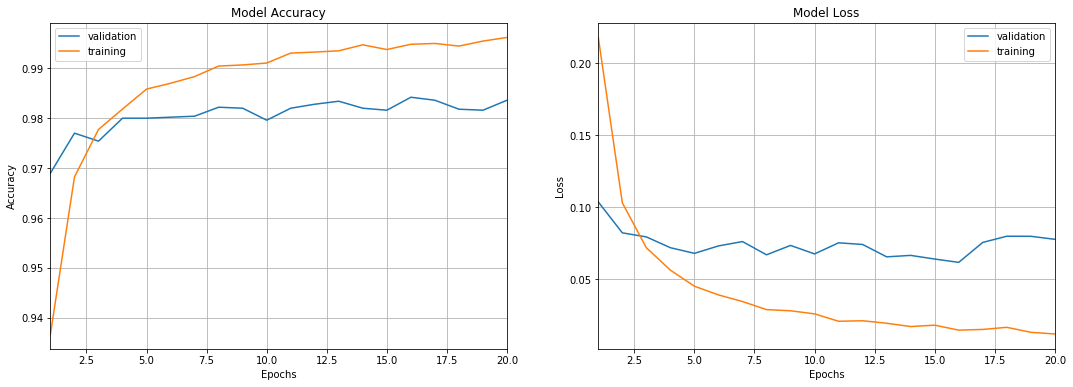

In [6]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Accuracy")

plt.subplot(122)
plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Model Loss")

plt.show() 